Processed frame 1/451
Processed frame 2/451
Processed frame 3/451
Processed frame 4/451
Processed frame 5/451
Processed frame 6/451
Processed frame 7/451
Processed frame 8/451


Processed frame 9/451
Processed frame 10/451
Processed frame 11/451
Processed frame 12/451
Processed frame 13/451
Processed frame 14/451
Processed frame 15/451
Processed frame 16/451
Processed frame 17/451
Processed frame 18/451
Processed frame 19/451
Processed frame 20/451
Processed frame 21/451
Processed frame 22/451
Processed frame 23/451
Processed frame 24/451
Processed frame 25/451
Processed frame 26/451
Processed frame 27/451
Processed frame 28/451
Processed frame 29/451
Processed frame 30/451
Processed frame 31/451
Processed frame 32/451
Processed frame 33/451
Processed frame 34/451
Processed frame 35/451
Processed frame 36/451
Processed frame 37/451
Processed frame 38/451
Processed frame 39/451
Processed frame 40/451
Processed frame 41/451
Processed frame 42/451
Processed frame 43/451
Processed frame 44/451
Processed frame 45/451
Processed frame 46/451
Processed frame 47/451
Processed frame 48/451
Processed frame 49/451
Processed frame 50/451
Processed frame 51/451
Processed fr

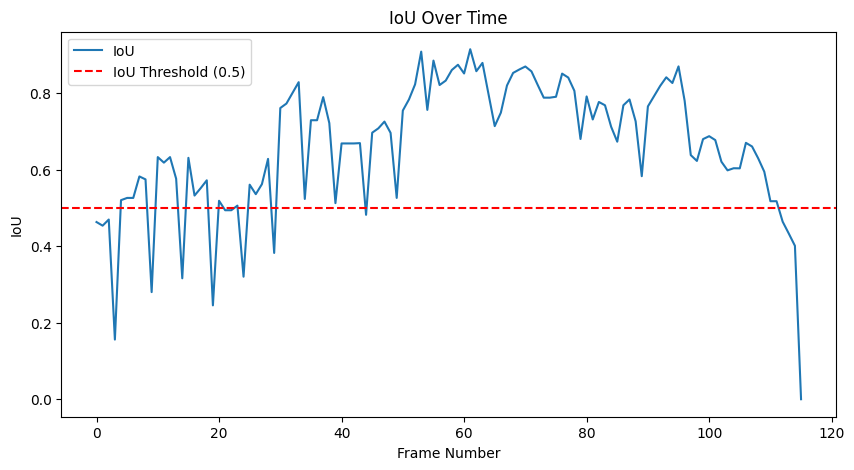

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to calculate Intersection over Union (IoU)
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Calculate area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate area of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

# Load ground truth data for object ID 8
gt_path = '/home/ubuntu/project_dl/dataset/onlyfootball/dataset/val/v_i2_L4qquVg0_c007/gt/gt.txt'
gt_data = []
with open(gt_path, 'r') as file:
    for line in file:
        parts = line.strip().split(', ')
        if int(parts[1]) == 1:  # Filter for object ID x
            gt_data.append((int(parts[2]), int(parts[3]), int(parts[4]), int(parts[5])))

# Set video path and initialize capture
video_path = '/home/ubuntu/project_dl/v_i2_L4qquVg0_c007.mp4'
cap = cv2.VideoCapture(video_path)

# Read first frame and manually set bounding box
ret, first_frame = cap.read()
if not ret:
    raise ValueError("Failed to read video")

# Manually define initial bounding box (x, y, width, height)
init_bbox = (747, 279, 30, 71)  # ADJUST THESE VALUES BASED ON YOUR FIRST FRAME

# Initialize CSRT tracker
tracker = cv2.TrackerCSRT_create()
tracker.init(first_frame, init_bbox)

# Get video properties for output
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Prepare output video writer
output_path = 'tracked_output_v_i2_L4qquVg0_c007_for_Evaluation.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Track movement path and centers
centers = []
tracking_path = []
iou_scores = []

# Process video frames
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    success, bbox = tracker.update(frame)

    if success:
        # Extract bounding box coordinates
        x, y, w, h = [int(v) for v in bbox]
        current_center = (x + w // 2, y + h // 2)
        centers.append(current_center)

        # Draw bounding box and path
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        if len(centers) > 1:
            cv2.polylines(frame, [np.array(centers, dtype=np.int32)], False, (0, 255, 0), 2)

        # Compare with ground truth
        if frame_count < len(gt_data):
            gt_bbox = gt_data[frame_count]
            iou = calculate_iou((x, y, w, h), gt_bbox)
            iou_scores.append(iou)
            cv2.putText(frame, f"IoU: {iou:.2f}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    else:
        cv2.putText(frame, "Tracking Lost", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        iou_scores.append(0.0)  # IoU is 0 if tracking is lost

    out.write(frame)
    frame_count += 1
    print(f"Processed frame {frame_count}/{total_frames}")

# Release resources
cap.release()
out.release()

# Calculate tracking accuracy
iou_threshold = 0.5  # Define a threshold for successful tracking
tracking_accuracy = sum(iou > iou_threshold for iou in iou_scores) / len(iou_scores) * 100
print(f"Tracking Accuracy (IoU > {iou_threshold}): {tracking_accuracy:.2f}%")

# Plot IoU over time
plt.figure(figsize=(10, 5))
plt.plot(iou_scores, label='IoU')
plt.axhline(y=iou_threshold, color='r', linestyle='--', label=f'IoU Threshold ({iou_threshold})')
plt.xlabel('Frame Number')
plt.ylabel('IoU')
plt.title('IoU Over Time')
plt.legend()
plt.show()